# Westeros multinode tutorial: Adding DACCS in climate mitigation scenario
In the previous tutorials, we have learnt how to create a baseline scenario (`westeros_baseline.ipynb`) and add emissions bounds (`westeros_emissions_bounds.ipynb`) to the baseline scenario. Here, we will show how to include an additional/new technology to a MESSAGE model. While the combination of currently existing technologies might be able to deliver the Paris targets, the deployment of some new technologies might improve the probability of meeting the targets and/or reducing the costs. These technologies include CO2 removal (CDR) technologies. Hence, in this tutorial, we will use direct air carbon capture and storage (DACCS) as an example of new technologies to be considered in climate mitigation pathways. 

In order to smoothly follow this tutorial, you have to alrady have the MESSAGEix framework installed and working. Additionally, you should have run the Westeros baseline and emissions bounds scenarios successfully as this tutorial is built on top of those scenarios.

If all set, we can start by importing all the packages we need and connect to a database that store the scenario input and results. We can also name the model as `Westeros Electrified` here.

In this tutorial, we will use add_dac tool which requires user to specify the location of the data, in yaml format. As such, we use os package to help us specifying the yaml file.

In [1]:
import os

import pandas as pd
import ixmp
import message_ix
import warnings
warnings.filterwarnings('ignore')

from message_ix.utils import make_df
from message_ix.tools.add_tech import add_tech



%matplotlib inline

mp = ixmp.Platform()

model = "Westeros Electrified"

<IPython.core.display.Javascript object>

After we are connected to the database, we can call the prevously run `"emission_bound"` scenario as our base model and clone the data before we start adding DACCS to the model. As prevoiusly mentioned, to run this tutorial, you have to have succesfully run the `"emission_bound"` scenario, which was built based on the `"baseline"` scenario.

In [2]:
base = message_ix.Scenario(mp, model=model, scenario="multinode_hub")

scenario = base.clone(
    model,
    "multinode_hub_emission_bound",
    "multinode_hub with emission bound",
    keep_solution=False,)
scenario.check_out()

year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scenario.set("year")
regions = [reg for reg in scenario.set("node") if reg not in ["World","hub"]]

This Scenario has a solution, use `Scenario.remove_solution()` or `Scenario.clone(..., keep_solution=False)`
Existing index sets of 'EMISSION_EQUIVALENCE' ['node', 'emission', 'type_tec', 'year'] do not match []


In [3]:
# add emission factor
# First we introduce the emission of CO2 and the emission category GHG
scenario.add_set("emission", "CO2")
scenario.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

model_years = sorted(list(set(act_years)))

# Last we add CO2 emissions factor to the coal powerplant
for reg in regions:
    emission_factor = make_df(
        "emission_factor",
        node_loc=reg,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        unit="tCO2/kWa",
        technology="coal_ppl",
        emission="CO2",
        value=7.4,
    )
    scenario.add_par("emission_factor", emission_factor)

In [4]:
scenario.set("map_node")

,node_parent,node
0,World,World
1,World,Westeros
2,Westeros,Westeros


In [5]:
# map regions to "World"
for reg in regions:
    if reg not in set(scenario.set("map_node")["node"]):
        scenario.add_set("map_node", ["World",reg])

In [6]:
# add emission bound
scenario.add_par(
    "bound_emission", ["World", "GHG", "all", "cumulative"], value=1500.0, unit="MtCO2"
)

**Solve scenario without DACCS**

In [7]:
scenario.commit(comment="Multinode scenario emission bound without daccs")
scenario.set_as_default()

scenario.solve()
scenario.var("OBJ")["lvl"]

print('Objective value: ', scenario.var("OBJ")["lvl"])

Objective value:  490718.46875


**Comparing results**

**--- Without emissions limit:**

In [8]:
base.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,166.445336,0.0
1,Westeros,light,useful,710,year,162.039539,0.0
2,Westeros,light,useful,720,year,161.002627,0.0
3,Essos,light,useful,700,year,166.445336,0.0
4,Essos,light,useful,710,year,162.039539,0.0
5,Essos,light,useful,720,year,161.002627,0.0
6,Stepstones,light,useful,700,year,161.402965,0.0
7,Stepstones,light,useful,710,year,162.039539,0.0
8,Stepstones,light,useful,720,year,161.002627,0.0


**--- With emissions limit:**

In [9]:
scenario.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,266.349390,0.0
1,Westeros,light,useful,710,year,317.023518,0.0
2,Westeros,light,useful,720,year,413.455198,0.0
3,Essos,light,useful,700,year,266.349390,0.0
4,Essos,light,useful,710,year,317.023518,0.0
5,Essos,light,useful,720,year,413.455198,0.0
6,Stepstones,light,useful,700,year,256.549684,0.0
7,Stepstones,light,useful,710,year,317.023518,0.0
8,Stepstones,light,useful,720,year,413.455198,0.0


# Adding DACCS description
First step of adding DACCS as a technology in the model is by including DACCS into the `"technology"` set.

In [10]:
dac_scenario = scenario.clone(
    model,
    "multinode_hub_emission_bound_dac",
    "multinode_hub with emission bound and dac",
    keep_solution=False,)
dac_scenario.check_out()

Existing index sets of 'EMISSION_EQUIVALENCE' ['node', 'emission', 'type_tec', 'year'] do not match []


In [11]:
mp.add_unit("USD/(tCO2/yr)")
mp.add_unit("USD/(tCO2/yr)/yr")
mp.add_unit("USD/tCO2")
mp.add_unit("tCO2/tCO2")
mp.add_unit("tCO2")
mp.add_unit("Mt CO2/yr")


filepath = os.path.join(os.getcwd(), "data/westeros_multinode_daccs_data.yaml")
add_tech(dac_scenario, filepath=filepath)

Similar to what we did when generating the `"baseline"` scenario, the first thing we need to do is defining the input and output comodities of each technology. 

# Solve Statement
Finally, this is the solve statement

In [12]:
dac_scenario.commit(comment="Multinode Emission Bound with DACCS")
dac_scenario.set_as_default()

dac_scenario.solve()
dac_scenario.var("OBJ")["lvl"]

print('Objective Value')
print('Without DACCS: ', scenario.var("OBJ")["lvl"])
print('With DACCS   : ', dac_scenario.var("OBJ")["lvl"])

Objective Value
Without DACCS:  490718.46875
With DACCS   :  474427.21875


# Plotting Results and Compare
Finally, this is the plotting results command to compare emissions bound scenarios with and without DACCS

In [13]:
# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots
import matplotlib.pyplot as plt

rep_ori = Reporter.from_scenario(scenario)
rep_new = Reporter.from_scenario(dac_scenario)

prepare_plots(rep_ori)
prepare_plots(rep_new)

## System acticity

Westeros


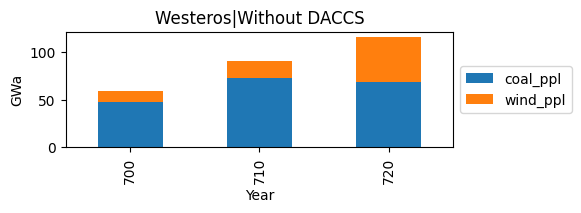

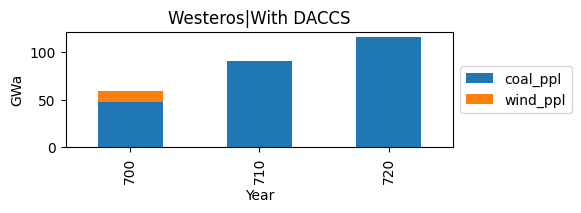

Essos


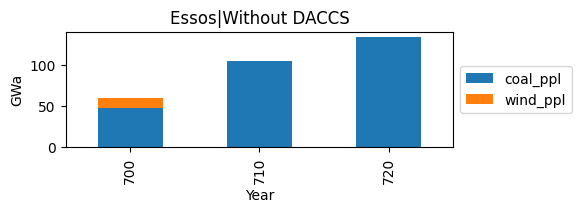

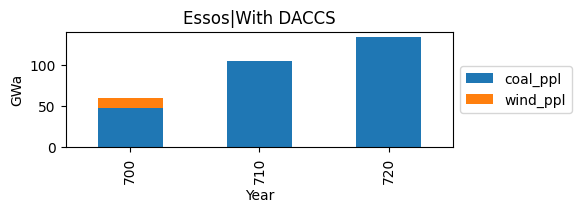

Stepstones


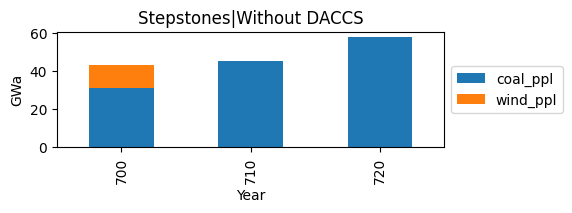

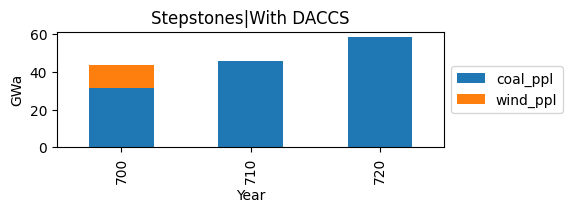

In [14]:
plt.rcParams["figure.figsize"] = (5,1.5)

for reg in regions:
    print(reg)
    
    filter_params = {"t":["coal_ppl", "wind_ppl"],"nl":reg}
    
    rep_ori.set_filters(**filter_params)
    rep_ori.get("plot activity")
    plt.title(reg+'|Without DACCS')
    
    rep_new.set_filters(**filter_params)
    rep_new.get("plot activity")
    plt.title(reg+'|With DACCS')
    plt.show()

## DACCS Capacity

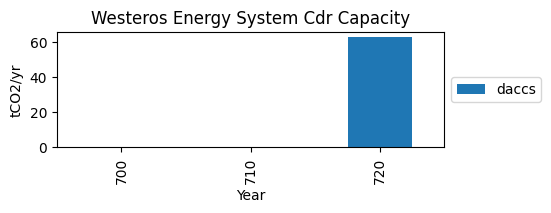

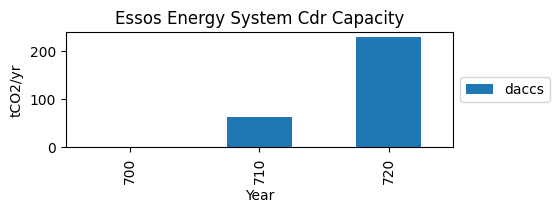

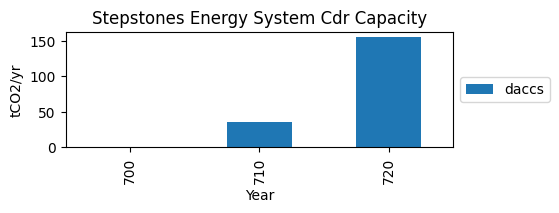

In [15]:
plt.rcParams["figure.figsize"] = (5,1.5)

for reg in regions:
    rep_new.set_filters(t=["daccs"],nl=reg)
    rep_new.get("plot cdr capacity")
    
plt.show()

## Emissions

Westeros


emission_factor: mixed units ['tCO2/kWa', 'tCO2/tCO2'] discarded


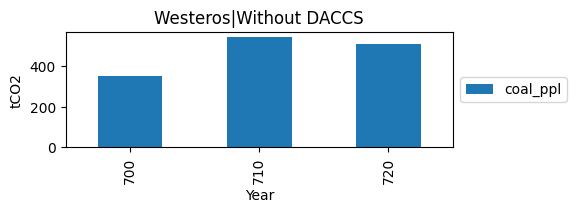

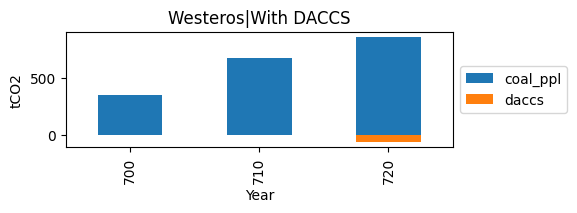

emission_factor: mixed units ['tCO2/kWa', 'tCO2/tCO2'] discarded


Essos


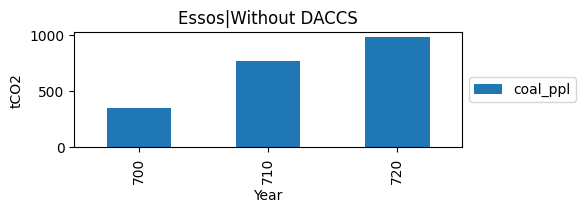

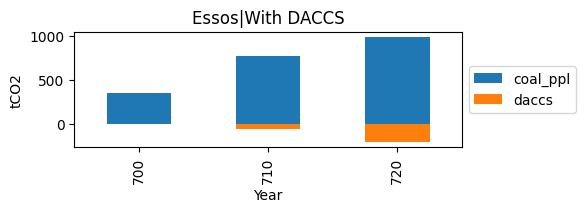

emission_factor: mixed units ['tCO2/kWa', 'tCO2/tCO2'] discarded


Stepstones


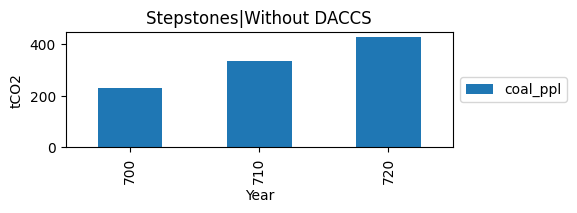

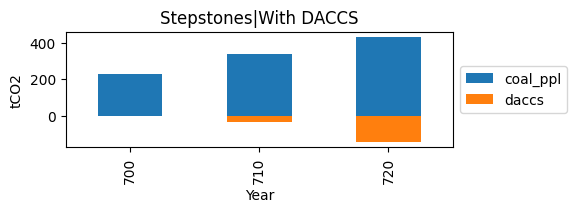

In [16]:
plt.rcParams["figure.figsize"] = (5,1.5)
        
for reg in regions:
    print(reg)
    filter_params = {"t":["coal_ppl", "wind_ppl","daccs"],"nl":reg}
    rep_ori.set_filters(**filter_params)
    rep_ori.get("plot emission")
    plt.title(reg+'|Without DACCS')

    rep_new.set_filters(**filter_params)
    rep_new.get("plot emission")
    plt.title(reg+'|With DACCS')
    plt.show()

**Comparing prices**

**--- Without DACCS:**

In [17]:
scenario.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,266.349390,0.0
1,Westeros,light,useful,710,year,317.023518,0.0
2,Westeros,light,useful,720,year,413.455198,0.0
3,Essos,light,useful,700,year,266.349390,0.0
4,Essos,light,useful,710,year,317.023518,0.0
5,Essos,light,useful,720,year,413.455198,0.0
6,Stepstones,light,useful,700,year,256.549684,0.0
7,Stepstones,light,useful,710,year,317.023518,0.0
8,Stepstones,light,useful,720,year,413.455198,0.0


**--- With DACCS:**

In [18]:
dac_scenario.var("PRICE_COMMODITY", {"commodity": "light"})

,node,commodity,level,year,time,lvl,mrg
0,Westeros,light,useful,700,year,232.262684,0.0
1,Westeros,light,useful,710,year,264.143849,0.0
2,Westeros,light,useful,720,year,327.319789,0.0
3,Essos,light,useful,700,year,232.262684,0.0
4,Essos,light,useful,710,year,264.143849,0.0
5,Essos,light,useful,720,year,327.319789,0.0
6,Stepstones,light,useful,700,year,224.086155,0.0
7,Stepstones,light,useful,710,year,264.143849,0.0
8,Stepstones,light,useful,720,year,327.319789,0.0


## Close the connection with the database

In [19]:
mp.close_db()